In [ ]:
import cv2
import numpy as np
import pandas as pd
import glob
import math
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import hsv_to_rgb

# 2D

## 1. Data Filter - Faded Silk

In [ ]:
def compute_saturation_and_hue_stats(image_path):
    """
    Load an image, exclude pure black and white regions, and compute saturation and hue statistics.
    """
    try:
        img_pil = Image.open(image_path).convert('RGB')
        img = np.array(img_pil)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

        hue = img_hsv[:, :, 0]
        sat = img_hsv[:, :, 1]
        val = img_hsv[:, :, 2]

        # Remove dead black areas (low brightness + low saturation)
        dead_black_mask = (val < 30) & (sat < 20)

        # Keep only valid pixels (neither black nor white)
        valid_mask = ~dead_black_mask

        sat_filtered = sat[valid_mask]
        hue_filtered = hue[valid_mask]

        if sat_filtered.size == 0 or hue_filtered.size == 0:
            return None, None, None, None

        return (
            np.mean(sat_filtered),
            np.std(sat_filtered),
            np.mean(hue_filtered),
            np.std(hue_filtered)
        )

    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None, None, None, None


In [3]:
def delete_img(avg_sat,mean_hue,std_hue):
    if (avg_sat < 150 and 5 < mean_hue < 25 and std_hue < 30) or (avg_sat < 110 and 25 <= mean_hue < 40 and std_hue < 25):
        return True
    else:
        return False
    
def process_image_folder(folder_path):
    records = []
    for ext in ('*.jpg', '*.jpeg', '*.png'):
        for path in glob.glob(os.path.join(folder_path, ext)):
            if '_restored' in os.path.basename(path):
                continue
            avg_sat, std_sat, mean_hue, std_hue = compute_saturation_and_hue_stats(path)
            if avg_sat is not None:
                records.append({
                    "filename": os.path.basename(path),
                    "avg_sat": avg_sat,
                    "std_sat": std_sat,
                    "mean_hue": mean_hue,
                    "std_hue": std_hue,
                    "delete": delete_img(avg_sat, mean_hue, std_hue)
                })
    return pd.DataFrame(records)

In [4]:
faded_folder = "..//data//Faded_Sample_Dataset"
clean_folder = "..//data//Non_Faded_Sample_Dataset"
df_faded = process_image_folder(faded_folder)
df_non_faded = process_image_folder(clean_folder)

In [22]:
df_faded

,filename,avg_sat,std_sat,mean_hue,std_hue,delete
0,Song069_original.jpg,114.836248,80.548506,18.587829,19.465486,True
1,包裹绢.png,123.322378,74.616257,36.057685,43.518722,False
2,折枝朵花纹纱罗裙 .png,86.295178,79.423105,67.054695,74.795347,False
3,折枝花鸟纹亮地纱裙 .png,92.764149,70.047326,14.008728,15.204629,True
4,散点回纹绫 .png,87.999108,89.929307,10.305103,16.492961,True
5,棕色绉纱 .png,27.444549,36.447482,79.837929,77.533981,False
6,绿色素罗 .png,77.287790,54.977873,14.551149,21.127177,True
7,缠枝团花绫短袖袍残片.png,144.693137,96.544064,12.376646,16.047700,True
8,高筒绢袜.png,73.744470,76.043045,72.290300,53.810734,False


In [23]:
df_non_faded

,filename,avg_sat,std_sat,mean_hue,std_hue,delete
0,Qing117.jpg,44.160726,62.796478,78.816687,42.452794,False
1,Qing121.jpg,106.682158,96.178840,26.011382,53.622944,False
2,Qing149.jpg,204.786893,42.340589,17.101431,9.119233,False
3,Song006.jpg,71.056708,49.747964,27.672864,29.202105,False
4,Song057.jpg,109.222512,91.391812,26.805811,32.582059,False
5,suitang04.jpg,179.612364,63.700365,20.844341,9.665576,False
6,suitang49.jpg,116.073900,81.248879,26.968491,17.317580,False
7,白绸印人物地景袖头.png,22.888842,18.422587,25.870781,29.276380,False
8,白缎绣龙凤女裙.png,34.552188,23.823270,24.238281,33.915691,False


## 2. draw plots

In [ ]:
def compute_average_hue_distribution(folder_list, bins=100):
    if isinstance(folder_list, str):
        folder_list = [folder_list]

    all_hists = []
    folder_stats = []  # For each folder: (included_count, excluded_count)

    for folder in folder_list:
        included_count = 0
        excluded_count = 0

        image_paths = []
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            image_paths.extend(glob.glob(os.path.join(folder, ext)))

        for path in image_paths:
            if '_restored' in os.path.basename(path):
                continue

            avg_sat, std_sat, mean_hue, std_hue = compute_saturation_and_hue_stats(path)
            if avg_sat is None or delete_img(avg_sat, mean_hue, std_hue):
                excluded_count += 1
                continue

            try:
                img_pil = Image.open(path).convert('RGB')
                img = np.array(img_pil)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

                hue = img_hsv[:, :, 0]
                sat = img_hsv[:, :, 1]
                val = img_hsv[:, :, 2]

                # Build mask for valid pixels
                black_mask = np.all(img < 30, axis=2)
                dead_mask = (val < 30) & (sat < 20)
                white_mask = (sat < 10) & (val > 220)
                low_sat_mask = sat < 50
                high_sat_mask = sat == 255
                valid_mask = ~(black_mask | dead_mask | white_mask | low_sat_mask | high_sat_mask)

                hue_filtered = hue[valid_mask]
                if hue_filtered.size == 0:
                    continue

                hue_norm = hue_filtered.flatten() / 180.0
                hist, _ = np.histogram(hue_norm, bins=bins, range=(0, 1))
                hist = hist / hist.sum() * 100  # Normalize to percentage
                all_hists.append(hist)
                included_count += 1

            except Exception:
                continue

        folder_stats.append((included_count, excluded_count))

    if not all_hists:
        return None, None, folder_stats

    average_hist = np.mean(all_hists, axis=0)
    x = np.linspace(0, 1, bins)
    return x, average_hist, folder_stats


In [26]:
def cache_hue_histogram_results(cache_dir, folders, bins=100):
    os.makedirs(cache_dir, exist_ok=True)
    cache_key = "_".join([os.path.basename(folder) for folder in folders])
    cache_path = os.path.join(cache_dir, f"{cache_key}_hist.json")

    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            data = json.load(f)
        x = np.array(data['x'])
        average_hist = np.array(data['average_hist'])
    else:
        x, average_hist, folder_stats = compute_average_hue_distribution(folders, bins=bins)
        print(f"Cached to: {cache_path}")
        for folder, (kept, removed) in zip(folders, folder_stats):
            print(f"{os.path.basename(folder)} — Kept: {kept}, Removed: {removed}")

        if x is not None and average_hist is not None:
            with open(cache_path, 'w') as f:
                json.dump({
                    'x': x.tolist(),
                    'average_hist': average_hist.tolist()
                }, f)

    return x, average_hist


In [ ]:
def plot_multiple_hue_subplots(base_path1, names1, base_path2=None, names2=None, bins=100, cache_dir="hue_cache"):
    """
    Plot multiple hue distribution subplots with segmented hue bands, labels, tick marks, and hidden x-axis.
    """

    if base_path2 is not None and names2 is not None:
        assert len(names1) == len(names2), "Mismatch in the number of folders in the two paths"
        folder_sets = [
            [os.path.join(base_path1, n1), os.path.join(base_path2, n2)]
            for n1, n2 in zip(names1, names2)
        ]
        titles = names2
    else:
        folder_sets = [[os.path.join(base_path1, n)] for n in names1]
        titles = names1

    cols = 3
    rows = (len(folder_sets) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows), sharex=True, sharey=True)
    axes = axes.flatten()

    # Perceptually adjusted hue segment definitions (non-uniform)
    segment_edges = [0.0, 0.04, 0.125, 0.21, 0.46, 0.54, 0.71, 0.875, 1.0]
    segment_labels = ['Red', 'Orange', 'Yellow', 'Green', 'Cyan', 'Blue', 'Purple', 'Pink-Red']

    for i, folders in enumerate(folder_sets):
        x, average_hist = cache_hue_histogram_results(cache_dir, folders, bins=bins)
        ax = axes[i]

        if average_hist is not None:
            ax.plot(x, average_hist, color='gray', linewidth=2)
            ax.fill_between(x, 0, average_hist, color='gray', alpha=0.5)

            # Add hue band strip (drawn from y = -1 to 0)
            for j in range(bins - 1):
                left = x[j]
                right = x[j + 1]
                width = right - left
                hue_val = (left + right) / 2
                rgb = hsv_to_rgb([hue_val % 1.0, 1, 1])
                ax.add_patch(Rectangle((left, -1), width, 1, color=rgb, linewidth=0))

            # Add segment labels and percentage
            for j in range(len(segment_edges) - 1):
                left = segment_edges[j]
                right = segment_edges[j + 1]
                mid = (left + right) / 2
                mask = (x >= left) & (x < right)
                pct = average_hist[mask].sum() / average_hist.sum() * 100

                ax.text(mid, -1.65, f"{segment_labels[j]}\n{pct:.1f}%", ha='center', va='top', fontsize=10)
                ax.axvline(left, ymin=0, ymax=0.02, color='white', linewidth=1)
            ax.axvline(segment_edges[-1], ymin=0, ymax=0.02, color='white', linewidth=1)

        ax.set_xlim(0, 1)
        ax.set_ylim(-1, 16)
        ax.set_title(titles[i], fontsize=20)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.spines['bottom'].set_visible(False)

    for j in range(len(folder_sets), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    save_path = "output/hue_distribution_plot_ymq.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()


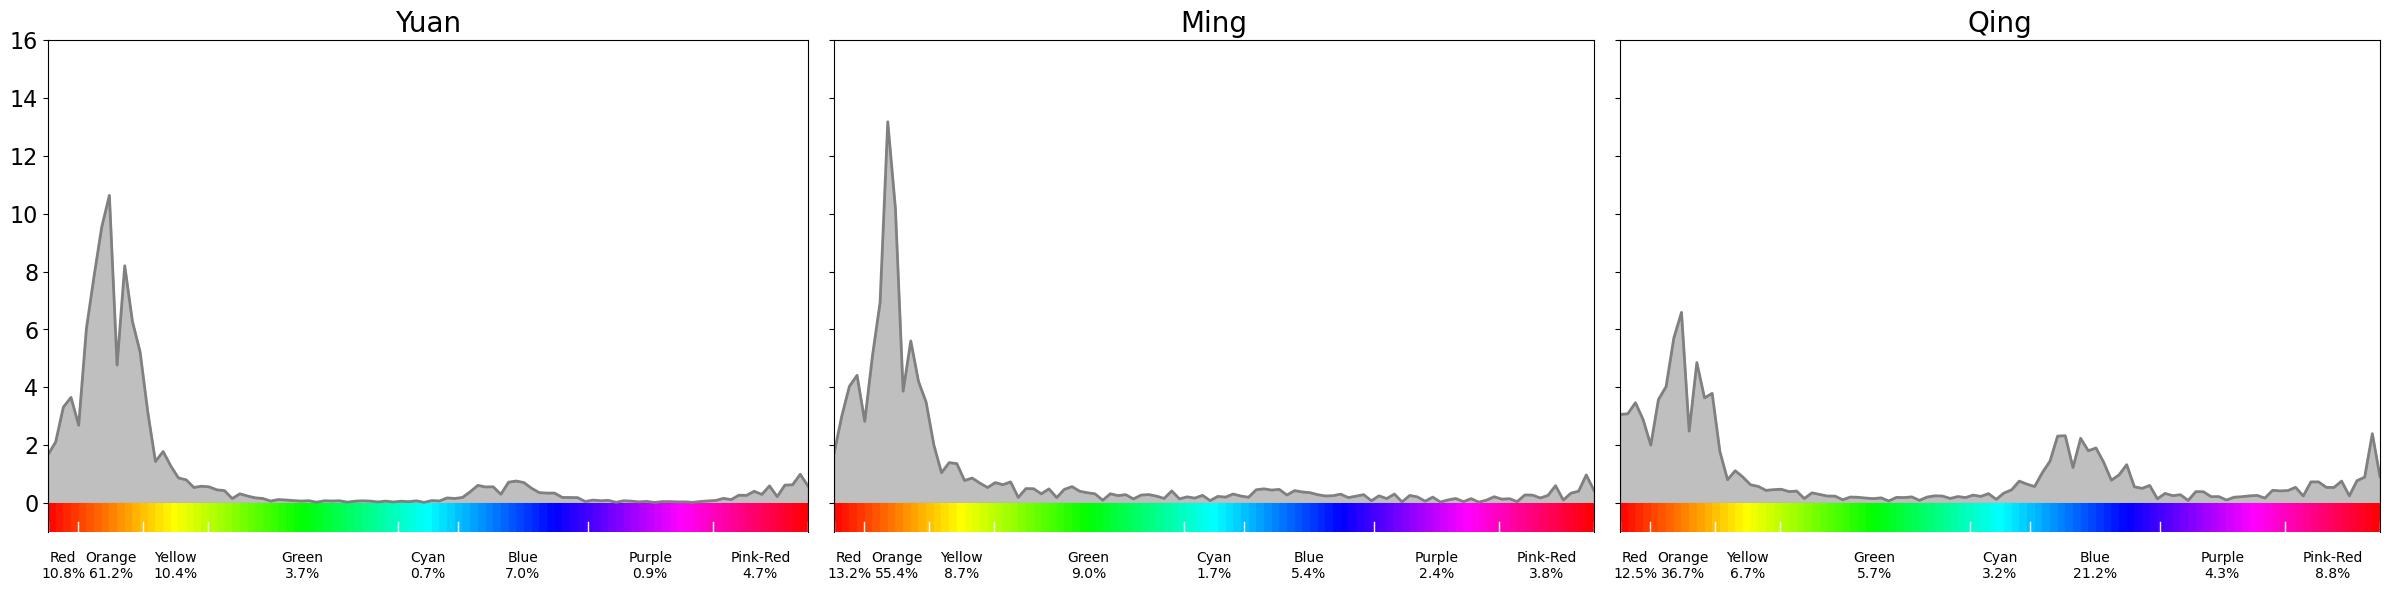

In [31]:
base_path1 = "..//data//Book_Dataset//"
#file_names1 = ['Suitang', 'Song', 'Yuan', 'Ming', 'Qing']
file_names1 = ['Yuan', 'Ming', 'Qing']
base_path2 = "..//data//Museum_Dataset//"
#file_names2 = ['Suitang', 'Song', 'Yuan', 'Ming', 'Qing']
file_names2 = ['Yuan', 'Ming', 'Qing']
plot_multiple_hue_subplots(
    base_path1
    ,file_names1
    ,base_path2
    ,file_names2
)

# 3D

In [ ]:
def compute_2d_hue_saturation_histogram(folder_list, sat_cutoff=50):
    """
    Compute a merged 2D hue-saturation histogram for multiple folders (normalize after merging all valid pixels).

    Parameters:
    - folder_list: list of folder paths
    - sat_cutoff: saturation threshold (pixels below this value are excluded)

    Returns:
    - total_hist: shape=(256, 180), percentage histogram (aggregated over all images)
    - folder_stats: (included_count, excluded_count) for each folder
    """
    if isinstance(folder_list, str):
        folder_list = [folder_list]

    total_hist = np.zeros((256, 180), dtype=np.float32)
    folder_stats = []

    for folder in folder_list:
        included_count = 0
        excluded_count = 0

        image_paths = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png')) and 'restored' not in f
        ]

        for path in image_paths:
            avg_sat, std_sat, mean_hue, std_hue = compute_saturation_and_hue_stats(path)
            if avg_sat is None or delete_img(avg_sat, mean_hue, std_hue):
                excluded_count += 1
                continue

            try:
                img_pil = Image.open(path).convert('RGB')
                img = np.array(img_pil)
                img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

                h = img_hsv[:, :, 0]
                s = img_hsv[:, :, 1]
                v = img_hsv[:, :, 2]

                # Mask: exclude low saturation, dead black, white, and over-saturated pixels
                black_mask = np.all(img < 30, axis=2)
                dead_mask = (v < 30) & (s < 20)
                white_mask = (s < 10) & (v > 220)
                low_sat_mask = s < sat_cutoff
                over_sat_mask = s == 255
                valid_mask = ~(black_mask | dead_mask | white_mask | low_sat_mask | over_sat_mask)

                h_valid = h[valid_mask]
                s_valid = s[valid_mask]

                if h_valid.size == 0:
                    excluded_count += 1
                    continue

                hist = cv2.calcHist(
                    [s_valid.astype(np.uint8), h_valid.astype(np.uint8)],
                    [0, 1],
                    None,
                    [256, 180],
                    [0, 256, 0, 180]
                )
                total_hist += hist  # Accumulate without normalization
                included_count += 1

            except Exception:
                excluded_count += 1
                continue

        folder_stats.append((included_count, excluded_count))

    total_hist = total_hist / total_hist.sum() * 100  # Normalize as percentage after merging all images
    return total_hist, folder_stats


In [6]:
def cache_3d_histogram_results(cache_dir, folders,):
    os.makedirs(cache_dir, exist_ok=True)
    cache_key = "_".join([os.path.basename(folder) for folder in folders])
    cache_path = os.path.join(cache_dir, f"{cache_key}_3dhist.json")

    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            data = json.load(f)
        total_hist = np.array(data['hist'])
    else:
        total_hist, folder_stats = compute_2d_hue_saturation_histogram(folders)

        print(f"Cached to: {cache_path}")
        for folder, (kept, removed) in zip(folders, folder_stats):
            print(f"{os.path.basename(folder)} — Kept: {kept}, Removed: {removed}")

        with open(cache_path, 'w') as f:
            json.dump({'hist': total_hist.tolist()}, f)

    return total_hist

In [ ]:
def plot_multiple_3d_hue_saturation_subplots(base_path1, names1, base_path2=None, names2=None, threshold_percent=20, cache_dir="hue_3d_cache"):
    """
    Plot individual 3D bar subplots of Hue-Saturation histograms for each folder and save as high-resolution image.
    """
    if base_path2 and names2:
        assert len(names1) == len(names2), "Mismatch in number of folders between the two paths"
        folder_list = [
            [os.path.join(base_path1, n1), os.path.join(base_path2, n2)]
            for n1, n2 in zip(names1, names2)
        ]
        titles = names2
    else:
        folder_list = [[os.path.join(base_path1, n)] for n in names1]
        titles = names1

    n = len(folder_list)
    cols = 3
    rows = math.ceil(n / cols)
    fig = plt.figure(figsize=(6 * cols, 8 * rows))

    for idx, folders in enumerate(folder_list):
        total_hist = cache_3d_histogram_results(cache_dir, folders)

        h_vals = np.arange(180)
        s_vals = np.arange(256)
        H, S = np.meshgrid(h_vals, s_vals)
        Z = total_hist

        threshold = np.percentile(Z, threshold_percent)
        mask = Z > threshold
        x = H[mask]
        y = S[mask]
        z = Z[mask].flatten()

        h_norm = x / 179.0
        s_norm = y / 255.0
        v = np.ones_like(h_norm)
        hsv = np.stack((h_norm, s_norm, v), axis=-1)
        rgb = hsv_to_rgb(hsv)

        ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
        if x.size > 0:
            ax.bar3d(x, y, np.zeros_like(z), 1, 1, z, color=rgb, shade=True)
        else:
            ax.text2D(0.3, 0.5, "No valid data", transform=ax.transAxes)

        ax.set_xlabel('Hue')
        ax.set_ylabel('Saturation')
        ax.set_xlim(0, 180)
        ax.set_ylim(50, 255)
        ax.set_zlim(0, 0.04)
        ax.set_zlabel('%')
        ax.set_title(titles[idx])

    for j in range(n, rows * cols):
        fig.delaxes(fig.add_subplot(rows, cols, j + 1))

    plt.tight_layout()

    save_path = "output/3d_hue_saturation_plot_ymq.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    print(f"Saved 3D plot to {save_path}")

    plt.show()


Saved 3D plot to output/3d_hue_saturation_plot_ymq.png


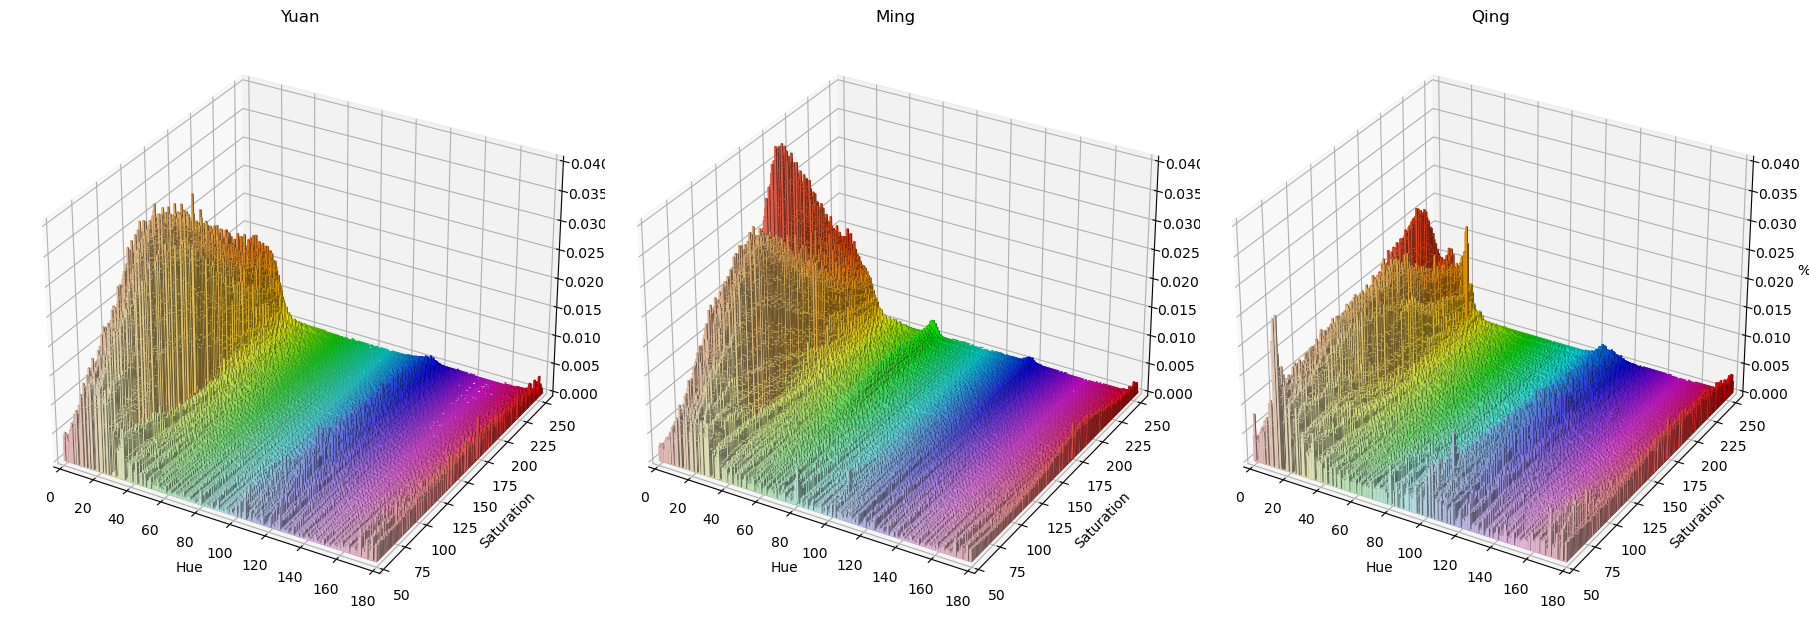

In [8]:
base_path1 = "..//data//Book_Dataset//"
file_names1 = ['Yuan', 'Ming', 'Qing']
# file_names1 = ['Suitang', 'Song', 'Yuan', 'Ming', 'Qing']
base_path2 = "..//data//Museum_Dataset//"
file_names2 = ['Yuan', 'Ming', 'Qing']
# file_names2 = ['Suitang', 'Song', 'Yuan', 'Ming', 'Qing']

plot_multiple_3d_hue_saturation_subplots(base_path1, file_names1, base_path2, file_names2)